In [388]:
# Import necessary libraries
import pandas as pd
import numpy as np
import db_utils, sqlalchemy
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
import math
import os
import gzip
import re
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
import time
from collections import Counter
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
#bbox_to_anchor =(1.0, 1.0)
import requests
save_path = '/Users/johgeist/Downloads/figure_publication_new2/'

In [278]:
# Define a function that removes a single element from a list or set if its length is greater than 1
def remove_single_element(x, other_set):
    if len(x) > 1:
        return list(set(x)- other_set)
    else:
        return x


# Define a function that retrieves Pfam domain names and short IDs from the EBI InterPro API based on Pfam IDs
def get_Pfam_names(pfam_ids):
    pfam_names = {}
    for pfam_id in pfam_ids:
        url = f'https://www.ebi.ac.uk/interpro/api/entry/pfam/{pfam_id}'
        response = requests.get(url)
        # Check the response
        if response.status_code == 200:
            data = response.json()
        else:
            print(f"Error {response.status_code}: {response.text}")
        #get name and short ID for the domain
        name = data['metadata']['name']['name']
        short = data['metadata']['name']['short']
        pfam_names[pfam_id] = [name, short]
        #pfam_short[pfam_id] = short
        time.sleep(1)
    return pfam_names
        
# Define function to modify ticks and lables of the plots
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,
                            fontsize=None):
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both')
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both')
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    if fontsize is not None:
        plt.tick_params(axis= 'both', labelsize= fontsize, bottom= False)
    else:
        global global_fontsize
        plt.tick_params(axis= 'both', labelsize= global_fontsize, bottom= False)

In [279]:
# HuRI only contains human proteins
# Fetch human proteins and their domains from mySQL table of the LuckLab
# They were originally obtained from InterPro filtering for all Pfam domains in humans
eng = sqlalchemy.create_engine('mysql://', creator= db_utils.get_connection)
query= pd.read_sql_query('''select UniProt_ID, Pfam_ID from chopyan_db.Pfam_domain_matches_human group by UniProt_ID, Pfam_ID;''', con= eng)
protein_domain_mapping = pd.DataFrame(query)
protein_domain_mapping

,UniProt_ID,Pfam_ID
0,A0A024RBG1,PF00293
1,A0A075B6H7,PF07686
2,A0A075B6H8,PF07686
3,A0A075B6H9,PF07686
4,A0A075B6I0,PF07686
...,...,...
30752,Q9YNA8,PF02337
30753,Q9YNA8,PF14787
30754,S4R3P1,PF15040
30755,S4R3Y5,PF15040


In [281]:
# Load the previously generated 3did subset containing DDI types supported by at least one interchain interface and
# one heterodimeric interaction and excluding those domains potentially associated with synthetic constructs as a 
# DataFrame
# Fetch all DDI types in 3did that make the determinde 80% approval chance cutoff of 4.47
filtered_3did = pd.read_csv('/Users/johgeist/Downloads/3did_project_dataframes_new/3did_Interactome_ProtCID_metrics_inter_hetero_subset_without_synthetic_constructs.csv')
cutoff_3did = filtered_3did.loc[filtered_3did['Zscore']>4.47, ['DDI_type','DomainID1', 'DomainID2', 'Zscore']]

In [282]:
cutoff_3did

,DDI_type,DomainID1,DomainID2,Zscore
0,PF00001_PF00048,PF00001,PF00048,5.10172
2,PF00001_PF00087,PF00001,PF00087,5.82806
3,PF00001_PF00322,PF00001,PF00322,7.36598
4,PF00001_PF00339,PF00001,PF00339,5.65710
6,PF00001_PF00503,PF00001,PF00503,5.98273
...,...,...,...,...
5253,PF18670_PF01992,PF18670,PF01992,4.52844
5254,PF18671_PF02901,PF18671,PF02901,6.55746
5257,PF18699_PF00829,PF18699,PF00829,5.19684
5262,PF18773_PF02792,PF18773,PF02792,4.50071


In [283]:
# Load in the HuRI network as a DataFrame
HuRI_ens = pd.read_csv('/Users/johgeist/Downloads/REAL_NETWORK.txt', sep='\t', skiprows=0)
HuRI_ens.columns = ['ens1', 'ens2']

In [284]:
HuRI_ens

,ens1,ens2
0,ENSG00000000005,ENSG00000061656
1,ENSG00000099968,ENSG00000000005
2,ENSG00000104765,ENSG00000000005
3,ENSG00000000005,ENSG00000105383
4,ENSG00000000005,ENSG00000114455
...,...,...
63198,ENSG00000275111,ENSG00000272804
63199,ENSG00000272804,ENSG00000277462
63200,ENSG00000272804,ENSG00000284341
63201,ENSG00000275302,ENSG00000278619


In [285]:
# Map from ENS IDs to UniProt IDs with previously done BioMart mapping (table is available in in MySQL database)
ENS_UP = pd.read_csv('/Users/johgeist/Downloads/ENSG_UniProt.csv', index_col=0)
ENS_UP

,ensembl_id,uniprot_id,hgnc_symbol,hgnc_id,id
0,ENSG00000284662,Q6IEY1,OR4F16,15079,1
1,ENSG00000186827,P43489,TNFRSF4,11918,2
2,ENSG00000157933,P12755,SKI,10896,3
3,ENSG00000169962,Q7RTX0,TAS1R3,15661,4
4,ENSG00000173673,Q5TGS1,HES3,26226,5
...,...,...,...,...,...
19394,ENSG00000236362,O76087,GAGE12F,31906,19395
19395,ENSG00000236362,P0CL82,GAGE12F,31906,19396
19396,ENSG00000215269,P0CL81,GAGE12G,31907,19397
19397,ENSG00000215269,O76087,GAGE12G,31907,19398


In [286]:
HuRI = HuRI_ens.copy()

# Merge for the first Ensembl ID column
HuRI = pd.merge(HuRI, ENS_UP[['ensembl_id', 'uniprot_id', 'hgnc_symbol']], left_on='ens1', right_on='ensembl_id', how='left')
HuRI.rename(columns={'uniprot_id': 'uniprot1', 'hgnc_symbol': 'gene_symbol1'}, inplace=True)
HuRI.drop(columns=['ensembl_id'], inplace=True)

# Merge for the second Ensembl ID column
HuRI = pd.merge(HuRI, ENS_UP[['ensembl_id', 'uniprot_id', 'hgnc_symbol']], left_on='ens2', right_on='ensembl_id', how='left')
HuRI.rename(columns={'uniprot_id': 'uniprot2', 'hgnc_symbol': 'gene_symbol2'}, inplace=True)
HuRI.drop(columns=['ensembl_id'], inplace=True)

HuRI

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2
0,ENSG00000000005,ENSG00000061656,Q9H2S6,TNMD,Q9NPE6,SPAG4
1,ENSG00000099968,ENSG00000000005,Q9BXK5,BCL2L13,Q9H2S6,TNMD
2,ENSG00000104765,ENSG00000000005,O60238,BNIP3L,Q9H2S6,TNMD
3,ENSG00000000005,ENSG00000105383,Q9H2S6,TNMD,P20138,CD33
4,ENSG00000000005,ENSG00000114455,Q9H2S6,TNMD,Q9UM44,HHLA2
...,...,...,...,...,...,...
63305,ENSG00000275111,ENSG00000272804,Q9BSG1,ZNF2,P60409,KRTAP10-7
63306,ENSG00000272804,ENSG00000277462,P60409,KRTAP10-7,Q9BS34,ZNF670
63307,ENSG00000272804,ENSG00000284341,P60409,KRTAP10-7,NaN,NaN
63308,ENSG00000275302,ENSG00000278619,P13236,CCL4,Q6IN84,MRM1


In [287]:
# Identify DDI matches in the interacting proteins in HuRI 2
DDI_matches_all = []
domain_up1 = []
domain_up2 = []

for _, row in HuRI.iterrows():
    prot1 = row['uniprot1']
    prot2 = row['uniprot2']
    domains1 = protein_domain_mapping.loc[protein_domain_mapping['UniProt_ID'] == prot1, 'Pfam_ID'].tolist()
    domains2 = protein_domain_mapping.loc[protein_domain_mapping['UniProt_ID'] == prot2, 'Pfam_ID'].tolist()
    DDI_matches = set() # make this as a set from the beginning!!
    domain_up1_row = set()
    domain_up2_row = set()
    for d1, d2 in zip(cutoff_3did['DomainID1'].tolist(), cutoff_3did['DomainID2'].tolist()):
        if (d1 in domains1) and (d2 in domains2):
            DDI_matches.add(f"{d1}_{d2}")
            domain_up1_row.add(d1)
            domain_up2_row.add(d2)
        elif (d1 in domains2) and (d2 in domains1):
            DDI_matches.add(f"{d1}_{d2}")
            domain_up1_row.add(d2)
            domain_up2_row.add(d1)

    DDI_matches_all.append(DDI_matches)
    domain_up1.append(domain_up1_row)
    domain_up2.append(domain_up2_row)


In [291]:
# Add the information on identified matches to the HuRI DataFrame along with the information
# about which protein carries which domain
HuRI['DDI_matches'] = DDI_matches_all
HuRI['Up1_domain'] = domain_up1
HuRI['Up2_domain'] = domain_up2

In [292]:
# Filter the HuRI DataFrame for those interactions exhibiting a DDI match
filtered_HuRI = HuRI[HuRI['DDI_matches'].apply(lambda x: bool(x))]

In [293]:
# Add the number of DDI matches per interaction as a column
filtered_HuRI = filtered_HuRI.copy()
filtered_HuRI['#_DDI_matches'] = filtered_HuRI['DDI_matches'].apply(len)

In [294]:
filtered_HuRI

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches
43,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,{PF02045_PF00808},{PF00808},{PF02045},1
79,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,{PF00452_PF10514},{PF10514},{PF00452},1
80,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,{PF00452_PF10514},{PF00452},{PF10514},1
143,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,{PF02301_PF05557},{PF02301},{PF05557},1
181,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,{PF14604_PF14604},{PF14604},{PF14604},1
...,...,...,...,...,...,...,...,...,...,...
62992,ENSG00000213760,ENSG00000250565,O95670,ATP6V1G2,Q96A05,ATP6V1E2,{PF03179_PF01991},{PF03179},{PF01991},1
62993,ENSG00000272047,ENSG00000213780,Q6ZYL4,GTF2H5,Q92759,GTF2H4,"{PF03849_PF06331, PF18307_PF06331}",{PF06331},"{PF18307, PF03849}",2
63152,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2
63153,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2


In [295]:
# Create a new column with sorted tuples of values in 'ens1' and 'ens2'
filtered_HuRI['sorted_PPI'] = filtered_HuRI[['ens1', 'ens2']].apply(lambda row: tuple(sorted(row)), axis=1)

# Identify and filter rows with the same values ens-ens combinations
duplicate_rows = filtered_HuRI[filtered_HuRI.duplicated(subset='sorted_PPI')]

duplicate_rows

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI
639,ENSG00000118507,ENSG00000005249,O43687,AKAP7,P31323,PRKAR2B,{PF10470_PF02197},{PF10470},{PF02197},1,"(ENSG00000005249, ENSG00000118507)"
4970,ENSG00000118507,ENSG00000064199,O43687,AKAP7,Q15506,SPA17,{PF10470_PF02197},{PF10470},{PF02197},1,"(ENSG00000064199, ENSG00000118507)"
23314,ENSG00000118507,ENSG00000108946,O43687,AKAP7,P10644,PRKAR1A,{PF10470_PF02197},{PF10470},{PF02197},1,"(ENSG00000108946, ENSG00000118507)"
26871,ENSG00000118507,ENSG00000114302,O43687,AKAP7,P13861,PRKAR2A,{PF10470_PF02197},{PF10470},{PF02197},1,"(ENSG00000114302, ENSG00000118507)"
29297,ENSG00000118507,ENSG00000188191,O43687,AKAP7,P31321,PRKAR1B,{PF10470_PF02197},{PF10470},{PF02197},1,"(ENSG00000118507, ENSG00000188191)"


In [296]:
# Drop duplicated PPIs
filtered_HuRI = filtered_HuRI.drop_duplicates(subset='sorted_PPI', keep='first')

In [297]:
filtered_HuRI

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI
43,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,{PF02045_PF00808},{PF00808},{PF02045},1,"(ENSG00000001167, ENSG00000120837)"
79,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,{PF00452_PF10514},{PF10514},{PF00452},1,"(ENSG00000002330, ENSG00000129473)"
80,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,{PF00452_PF10514},{PF00452},{PF10514},1,"(ENSG00000002330, ENSG00000171552)"
143,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,{PF02301_PF05557},{PF02301},{PF05557},1,"(ENSG00000002822, ENSG00000164109)"
181,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,{PF14604_PF14604},{PF14604},{PF14604},1,"(ENSG00000002834, ENSG00000130762)"
...,...,...,...,...,...,...,...,...,...,...,...
62992,ENSG00000213760,ENSG00000250565,O95670,ATP6V1G2,Q96A05,ATP6V1E2,{PF03179_PF01991},{PF03179},{PF01991},1,"(ENSG00000213760, ENSG00000250565)"
62993,ENSG00000272047,ENSG00000213780,Q6ZYL4,GTF2H5,Q92759,GTF2H4,"{PF03849_PF06331, PF18307_PF06331}",{PF06331},"{PF18307, PF03849}",2,"(ENSG00000213780, ENSG00000272047)"
63152,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2,"(ENSG00000233822, ENSG00000272196)"
63153,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2,"(ENSG00000233822, ENSG00000277075)"


In [300]:
# Generate a DataFrame holding the number of occurrences for each DDI type in the filtered HuRI network
freq_DDIs=[]
for DDI_type in cutoff_3did['DDI_type'].tolist():
    freq_DDI= filtered_HuRI['DDI_matches'].apply(lambda s: DDI_type in s).sum()
    freq_DDIs.append(freq_DDI)

freq_df = pd.DataFrame({'DDI_type': cutoff_3did['DDI_type'].tolist(), 'freq': freq_DDIs})

In [302]:
# Generate a subset of freq_df that holds only those DDI types with > 10 occurrences in the network
min_10_occ = freq_df.loc[freq_df['freq']>=10, 'DDI_type'].tolist()

In [303]:
# Get the number of DDIs out of the obtained 3did subset present in the network
freq_df_not_null = freq_df[freq_df['freq']!=0]
len(freq_df_not_null)

342

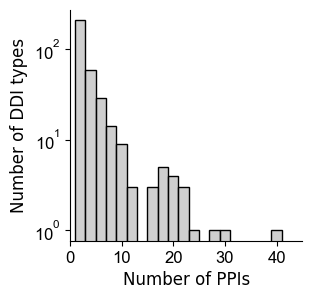

In [402]:
# Plot a histogram visualizing the number of PPIs a DDI is found in in the network

sns.reset_orig()
fig, axes = plt.subplots(figsize=figsize)
sns.histplot(data=freq_df_not_null, x='freq', binwidth=2, color='silver', edgecolor= 'black', linewidth= 1)
axes.set_xlim(0,45) # cuts 2 outliers
plt.yscale('log')
plt.xticks(fontname="Arial", fontsize= global_fontsize)
plt.yticks(fontname="Arial", fontsize= global_fontsize)
axes.set_ylabel('Number of DDI types', fontsize= global_fontsize)
axes.set_xlabel('Number of PPIs', fontsize= global_fontsize)
axes.minorticks_off()
# Remove the top and right spines
sns.despine(top=True, right=True)
#plt.savefig(f'{save_path}Hist_PPIs_per_DDI.pdf', transparent=True, bbox_inches='tight')
plt.show()

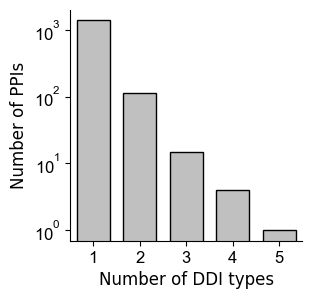

In [404]:
# Plot a barplot visualizign how many DDI interfaces there are per interaction in the network

data_y = [len(filtered_HuRI[filtered_HuRI['#_DDI_matches']== i]) for i in [1,2,3,4,5]]

fig, axes = plt.subplots(figsize=figsize)
sns.barplot(x= [1,2,3,4,5], y= data_y, color= 'silver', edgecolor= 'black', linewidth= 1, width=0.7)
axes.set_ylabel('Number of PPIs', fontsize= global_fontsize)
axes.set_xlabel('Number of DDI types', fontsize= global_fontsize)
plt.xticks(fontname="Arial", fontsize= global_fontsize)
plt.yticks(fontname="Arial", fontsize= global_fontsize)
plt.yscale('log')
axes.minorticks_off()
# Remove the top and right spines
sns.despine(top=True, right=True)
#plt.savefig(f'{save_path}Hist_DDIs_per_PPIs.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [309]:
filtered_HuRI[filtered_HuRI['#_DDI_matches']==1]

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI
43,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,{PF02045_PF00808},{PF00808},{PF02045},1,"(ENSG00000001167, ENSG00000120837)"
79,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,{PF00452_PF10514},{PF10514},{PF00452},1,"(ENSG00000002330, ENSG00000129473)"
80,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,{PF00452_PF10514},{PF00452},{PF10514},1,"(ENSG00000002330, ENSG00000171552)"
143,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,{PF02301_PF05557},{PF02301},{PF05557},1,"(ENSG00000002822, ENSG00000164109)"
181,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,{PF14604_PF14604},{PF14604},{PF14604},1,"(ENSG00000002834, ENSG00000130762)"
...,...,...,...,...,...,...,...,...,...,...,...
62809,ENSG00000206172,ENSG00000223609,P69905,HBA1,P02042,HBD,{PF00042_PF00042},{PF00042},{PF00042},1,"(ENSG00000206172, ENSG00000223609)"
62810,ENSG00000244734,ENSG00000206172,P68871,HBB,P69905,HBA1,{PF00042_PF00042},{PF00042},{PF00042},1,"(ENSG00000206172, ENSG00000244734)"
62813,ENSG00000244734,ENSG00000206177,P68871,HBB,Q6B0K9,HBM,{PF00042_PF00042},{PF00042},{PF00042},1,"(ENSG00000206177, ENSG00000244734)"
62978,ENSG00000231989,ENSG00000213639,Q6NXS1,PPP1R2B,P62140,PPP1CB,{PF04979_PF00149},{PF04979},{PF00149},1,"(ENSG00000213639, ENSG00000231989)"


In [310]:
filtered_HuRI[filtered_HuRI['#_DDI_matches']==2]

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI
730,ENSG00000006125,ENSG00000129354,P63010,AP2B1,Q9Y6Q5,AP1M2,"{PF00928_PF01602, PF01602_PF01217}",{PF01602},"{PF00928, PF01217}",2,"(ENSG00000006125, ENSG00000129354)"
743,ENSG00000006125,ENSG00000161203,P63010,AP2B1,Q96CW1,AP2M1,"{PF00928_PF01602, PF01602_PF01217}",{PF01602},"{PF00928, PF01217}",2,"(ENSG00000006125, ENSG00000161203)"
1811,ENSG00000087191,ENSG00000013275,P62195,PSMC5,P43686,PSMC4,"{PF00004_PF00004, PF16450_PF16450}","{PF16450, PF00004}","{PF16450, PF00004}",2,"(ENSG00000013275, ENSG00000087191)"
2181,ENSG00000164675,ENSG00000019995,Q8NA54,IQUB,Q9UGI0,ZRANB1,"{PF02338_PF00240, PF00240_PF00641}",{PF00240},"{PF00641, PF02338}",2,"(ENSG00000019995, ENSG00000164675)"
3253,ENSG00000101182,ENSG00000041357,O14818,PSMA7,P25789,PSMA4,"{PF00227_PF00227, PF10584_PF10584}","{PF10584, PF00227}","{PF10584, PF00227}",2,"(ENSG00000041357, ENSG00000101182)"
...,...,...,...,...,...,...,...,...,...,...,...
62507,ENSG00000233822,ENSG00000203812,Q99877,H2BC15,Q6FI13,H2AC18,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2,"(ENSG00000203812, ENSG00000233822)"
62993,ENSG00000272047,ENSG00000213780,Q6ZYL4,GTF2H5,Q92759,GTF2H4,"{PF03849_PF06331, PF18307_PF06331}",{PF06331},"{PF18307, PF03849}",2,"(ENSG00000213780, ENSG00000272047)"
63152,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2,"(ENSG00000233822, ENSG00000272196)"
63153,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,"{PF00125_PF16211, PF00125_PF00125}",{PF00125},"{PF00125, PF16211}",2,"(ENSG00000233822, ENSG00000277075)"


In [311]:
len(filtered_HuRI[filtered_HuRI['#_DDI_matches']==3])

15

In [312]:
len(filtered_HuRI[filtered_HuRI['#_DDI_matches']==4])

4

In [313]:
len(filtered_HuRI[filtered_HuRI['#_DDI_matches']==5])

1

In [314]:
filtered_HuRI.to_csv(f'{save_path}filtered_HuRI.csv')

In [344]:
# Change DataFrame to better match requirements of Cytoscape
# Change format of the dataframe do every DDI gets a single row
df_exploded = filtered_HuRI.explode('DDI_matches').reset_index(drop=True)

# Extract unique proteins from 'Up1_domain' and 'Up2_domain' based on the new 'interaction' column
df_exploded['DDI_set'] = df_exploded['DDI_matches'].apply(lambda x: set(x.split('_')))
df_exploded['Up1_domain'] = df_exploded.apply(lambda row: row['Up1_domain'] & row['DDI_set'], axis=1)
df_exploded['Up2_domain'] = df_exploded.apply(lambda row: row['Up2_domain'] & row['DDI_set'], axis=1)

# # Drop the temporary 'interaction_set' column
# df_exploded = df_exploded.drop('DDI_set', axis=1)

In [345]:
df_exploded

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI,DDI_set
0,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,PF02045_PF00808,{PF00808},{PF02045},1,"(ENSG00000001167, ENSG00000120837)","{PF00808, PF02045}"
1,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,PF00452_PF10514,{PF10514},{PF00452},1,"(ENSG00000002330, ENSG00000129473)","{PF10514, PF00452}"
2,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,PF00452_PF10514,{PF00452},{PF10514},1,"(ENSG00000002330, ENSG00000171552)","{PF10514, PF00452}"
3,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,PF02301_PF05557,{PF02301},{PF05557},1,"(ENSG00000002822, ENSG00000164109)","{PF05557, PF02301}"
4,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,PF14604_PF14604,{PF14604},{PF14604},1,"(ENSG00000002834, ENSG00000130762)",{PF14604}
...,...,...,...,...,...,...,...,...,...,...,...,...
1689,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,PF00125_PF00125,{PF00125},{PF00125},2,"(ENSG00000233822, ENSG00000272196)",{PF00125}
1690,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF16211,{PF00125},"{PF00125, PF16211}",2,"(ENSG00000233822, ENSG00000277075)","{PF00125, PF16211}"
1691,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF00125,{PF00125},{PF00125},2,"(ENSG00000233822, ENSG00000277075)",{PF00125}
1692,ENSG00000233822,ENSG00000278463,Q99877,H2BC15,P04908,H2AC4,PF00125_PF16211,{PF00125},"{PF00125, PF16211}",2,"(ENSG00000233822, ENSG00000278463)","{PF00125, PF16211}"


In [346]:
# Find rows where 'Up1_domain' or 'Up2_domain' has a set with only one element,
# and the other 'Up_domain' column has a set with more than one element
single_element_mask = (
    ((df_exploded['Up1_domain'].apply(len) == 1) & (df_exploded['Up2_domain'].apply(len) > 1)) |
    ((df_exploded['Up2_domain'].apply(len) == 1) & (df_exploded['Up1_domain'].apply(len) > 1))
)

# Update the DataFrame by removing the single element from the other 'Up_domain' column
df_exploded.loc[single_element_mask, 'Up1_domain'] = df_exploded.loc[single_element_mask].apply(lambda row: remove_single_element(row['Up1_domain'], row['Up2_domain']), axis=1)
df_exploded.loc[single_element_mask, 'Up2_domain'] = df_exploded.loc[single_element_mask].apply(lambda row: remove_single_element(row['Up2_domain'], row['Up1_domain']), axis=1)

In [347]:
df_exploded

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI,DDI_set
0,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,PF02045_PF00808,{PF00808},{PF02045},1,"(ENSG00000001167, ENSG00000120837)","{PF00808, PF02045}"
1,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,PF00452_PF10514,{PF10514},{PF00452},1,"(ENSG00000002330, ENSG00000129473)","{PF10514, PF00452}"
2,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,PF00452_PF10514,{PF00452},{PF10514},1,"(ENSG00000002330, ENSG00000171552)","{PF10514, PF00452}"
3,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,PF02301_PF05557,{PF02301},{PF05557},1,"(ENSG00000002822, ENSG00000164109)","{PF05557, PF02301}"
4,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,PF14604_PF14604,{PF14604},{PF14604},1,"(ENSG00000002834, ENSG00000130762)",{PF14604}
...,...,...,...,...,...,...,...,...,...,...,...,...
1689,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,PF00125_PF00125,{PF00125},{PF00125},2,"(ENSG00000233822, ENSG00000272196)",{PF00125}
1690,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF16211,{PF00125},[PF16211],2,"(ENSG00000233822, ENSG00000277075)","{PF00125, PF16211}"
1691,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF00125,{PF00125},{PF00125},2,"(ENSG00000233822, ENSG00000277075)",{PF00125}
1692,ENSG00000233822,ENSG00000278463,Q99877,H2BC15,P04908,H2AC4,PF00125_PF16211,{PF00125},[PF16211],2,"(ENSG00000233822, ENSG00000278463)","{PF00125, PF16211}"


In [348]:
# Convert the 'Up_domain' columns to strings
df_exploded['Up1_domain'] = df_exploded['Up1_domain'].apply(lambda x: ', '.join(x) if x else '')
df_exploded['Up2_domain'] = df_exploded['Up2_domain'].apply(lambda x: ', '.join(x) if x else '')
# Make the sorted_PPI column more addressable
df_exploded['sorted_PPI'] = df_exploded['sorted_PPI'].str.join('_')
# Drop DDI_set column, not necessary 
df_exploded=df_exploded.drop(columns=['DDI_set'])

In [349]:
df_exploded

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI
0,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,PF02045_PF00808,PF00808,PF02045,1,ENSG00000001167_ENSG00000120837
1,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,PF00452_PF10514,PF10514,PF00452,1,ENSG00000002330_ENSG00000129473
2,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,PF00452_PF10514,PF00452,PF10514,1,ENSG00000002330_ENSG00000171552
3,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,PF02301_PF05557,PF02301,PF05557,1,ENSG00000002822_ENSG00000164109
4,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,PF14604_PF14604,PF14604,PF14604,1,ENSG00000002834_ENSG00000130762
...,...,...,...,...,...,...,...,...,...,...,...
1689,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000272196
1690,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000277075
1691,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000277075
1692,ENSG00000233822,ENSG00000278463,Q99877,H2BC15,P04908,H2AC4,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000278463


In [351]:
# Add Pfam names
# Derive a list of all domains present in the network
domains = set()
for i in df_exploded['DDI_matches'].tolist():
    d1,d2 = i.split('_')
    domains.add(d1)
    domains.add(d2)    
domains = list(domains)

In [356]:
# Use the get_Pfam_names function defined earlier to retrieve the Pfam name and short name of the Pfam IDs in the
# domains list
pfam_dict= get_Pfam_names(domains)

In [358]:
# Create a DataFrame holding the Pfam IDs of the domains present in potential interfaces in the network along with
# their respective Pfam name and short name
df_pfam = pd.DataFrame(list(pfam_dict.items()), columns=['Pfam', 'names'])
df_pfam['name'] = df_pfam['names'].apply(lambda x: x[0] if x else None)
df_pfam['short'] = df_pfam['names'].apply(lambda x: x[1] if len(x) > 1 else None)
df_pfam= df_pfam.drop(columns=['names'])

In [360]:
df_pfam_sorted = df_pfam.sort_values(by='Pfam', ascending=True).reset_index()

In [361]:
df_pfam

,Pfam,name,short
0,PF13589,"Histidine kinase-, DNA gyrase B-, and HSP90-li...",HATPase_c_3
1,PF13238,AAA domain,AAA_18
2,PF06058,Dcp1-like decapping family,DCP1
3,PF13646,HEAT repeats,HEAT_2
4,PF00104,Ligand-binding domain of nuclear hormone receptor,Hormone_recep
...,...,...,...
408,PF05712,MRG,MRG
409,PF12850,Calcineurin-like phosphoesterase superfamily d...,Metallophos_2
410,PF04427,Brix domain,Brix
411,PF01900,Rpp14/Pop5 family,RNase_P_Rpp14


In [364]:
df_exploded

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_matches,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI
0,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,PF02045_PF00808,PF00808,PF02045,1,ENSG00000001167_ENSG00000120837
1,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,PF00452_PF10514,PF10514,PF00452,1,ENSG00000002330_ENSG00000129473
2,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,PF00452_PF10514,PF00452,PF10514,1,ENSG00000002330_ENSG00000171552
3,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,PF02301_PF05557,PF02301,PF05557,1,ENSG00000002822_ENSG00000164109
4,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,PF14604_PF14604,PF14604,PF14604,1,ENSG00000002834_ENSG00000130762
...,...,...,...,...,...,...,...,...,...,...,...
1689,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000272196
1690,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000277075
1691,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000277075
1692,ENSG00000233822,ENSG00000278463,Q99877,H2BC15,P04908,H2AC4,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000278463


In [365]:
# Add the Pfam names and short names to the exploded_df for ech of the two Pfam IDs in each row
merged_df = pd.merge(df_exploded, df_pfam_sorted, left_on='Up1_domain', right_on='Pfam', how='left')
merged_df = merged_df.drop(columns= ['Pfam', 'index'], axis=1)
merged_df.rename({'name': 'domain_name1', 'short': 'short_name1', 'DDI_matches': 'DDI_type'}, axis=1, inplace=True)
merged_df = pd.merge(merged_df, df_pfam_sorted, left_on='Up2_domain', right_on='Pfam', how='left')
merged_df = merged_df.drop(columns= ['Pfam', 'index'], axis=1)
merged_df.rename({'name': 'domain_name2', 'short': 'short_name2'}, axis=1, inplace=True)

In [366]:
merged_df

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_type,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI,domain_name1,short_name1,domain_name2,short_name2
0,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,PF02045_PF00808,PF00808,PF02045,1,ENSG00000001167_ENSG00000120837,Histone-like transcription factor (CBF/NF-Y) a...,CBFD_NFYB_HMF,CCAAT-binding transcription factor (CBF-B/NF-Y...,CBFB_NFYA
1,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,PF00452_PF10514,PF10514,PF00452,1,ENSG00000002330_ENSG00000129473,"Pro-apoptotic Bcl-2 protein, BAD",Bcl-2_BAD,"Apoptosis regulator proteins, Bcl-2 family",Bcl-2
2,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,PF00452_PF10514,PF00452,PF10514,1,ENSG00000002330_ENSG00000171552,"Apoptosis regulator proteins, Bcl-2 family",Bcl-2,"Pro-apoptotic Bcl-2 protein, BAD",Bcl-2_BAD
3,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,PF02301_PF05557,PF02301,PF05557,1,ENSG00000002822_ENSG00000164109,HORMA domain,HORMA,Mitotic checkpoint protein,MAD
4,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,PF14604_PF14604,PF14604,PF14604,1,ENSG00000002834_ENSG00000130762,Variant SH3 domain,SH3_9,Variant SH3 domain,SH3_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000272196,Core histone H2A/H2B/H3/H4,Histone,Core histone H2A/H2B/H3/H4,Histone
1690,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000277075,Core histone H2A/H2B/H3/H4,Histone,C-terminus of histone H2A,Histone_H2A_C
1691,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000277075,Core histone H2A/H2B/H3/H4,Histone,Core histone H2A/H2B/H3/H4,Histone
1692,ENSG00000233822,ENSG00000278463,Q99877,H2BC15,P04908,H2AC4,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000278463,Core histone H2A/H2B/H3/H4,Histone,C-terminus of histone H2A,Histone_H2A_C


In [367]:
merged_df.to_csv('/Users/johgeist/Downloads/preliminary_figures/HuRI_network_complete.csv')

In [368]:
# Create a subset of df_exploded holding only those DDI types occurring >10 times in HuRI
merged_small = merged_df[merged_df['DDI_type'].isin(min_10_occ)]
merged_small.to_csv('/Users/johgeist/Downloads/preliminary_figures/HuRI_network_small.csv')

In [369]:
merged_df

,ens1,ens2,uniprot1,gene_symbol1,uniprot2,gene_symbol2,DDI_type,Up1_domain,Up2_domain,#_DDI_matches,sorted_PPI,domain_name1,short_name1,domain_name2,short_name2
0,ENSG00000120837,ENSG00000001167,P25208,NFYB,P23511,NFYA,PF02045_PF00808,PF00808,PF02045,1,ENSG00000001167_ENSG00000120837,Histone-like transcription factor (CBF/NF-Y) a...,CBFD_NFYB_HMF,CCAAT-binding transcription factor (CBF-B/NF-Y...,CBFB_NFYA
1,ENSG00000002330,ENSG00000129473,Q92934,BAD,Q92843,BCL2L2,PF00452_PF10514,PF10514,PF00452,1,ENSG00000002330_ENSG00000129473,"Pro-apoptotic Bcl-2 protein, BAD",Bcl-2_BAD,"Apoptosis regulator proteins, Bcl-2 family",Bcl-2
2,ENSG00000171552,ENSG00000002330,Q07817,BCL2L1,Q92934,BAD,PF00452_PF10514,PF00452,PF10514,1,ENSG00000002330_ENSG00000171552,"Apoptosis regulator proteins, Bcl-2 family",Bcl-2,"Pro-apoptotic Bcl-2 protein, BAD",Bcl-2_BAD
3,ENSG00000164109,ENSG00000002822,Q13257,MAD2L1,Q9Y6D9,MAD1L1,PF02301_PF05557,PF02301,PF05557,1,ENSG00000002822_ENSG00000164109,HORMA domain,HORMA,Mitotic checkpoint protein,MAD
4,ENSG00000002834,ENSG00000130762,Q14847,LASP1,Q5VV41,ARHGEF16,PF14604_PF14604,PF14604,PF14604,1,ENSG00000002834_ENSG00000130762,Variant SH3 domain,SH3_9,Variant SH3 domain,SH3_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,ENSG00000233822,ENSG00000272196,Q99877,H2BC15,Q6FI13,H2AC19,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000272196,Core histone H2A/H2B/H3/H4,Histone,Core histone H2A/H2B/H3/H4,Histone
1690,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000277075,Core histone H2A/H2B/H3/H4,Histone,C-terminus of histone H2A,Histone_H2A_C
1691,ENSG00000233822,ENSG00000277075,Q99877,H2BC15,P04908,H2AC8,PF00125_PF00125,PF00125,PF00125,2,ENSG00000233822_ENSG00000277075,Core histone H2A/H2B/H3/H4,Histone,Core histone H2A/H2B/H3/H4,Histone
1692,ENSG00000233822,ENSG00000278463,Q99877,H2BC15,P04908,H2AC4,PF00125_PF16211,PF00125,PF16211,2,ENSG00000233822_ENSG00000278463,Core histone H2A/H2B/H3/H4,Histone,C-terminus of histone H2A,Histone_H2A_C
